In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import healpy as hp

import yaml

from Qatmosphere_2d import Atmosphere_Maps

import scipy
import scipy.special as sci_spe
import time
from astropy.time import TimeDelta
 
import sys
import yaml

sys.path.append('/home/laclavere/qubic/qubic/Pipeline')

import qubic
from qubic.lib.Qscene import QubicScene

from pyoperators.iterative.core import AbnormalStopIteration
from pysimulators import (
    CartesianEquatorial2GalacticOperator,
    CartesianEquatorial2HorizontalOperator,
    CartesianHorizontal2EquatorialOperator,
    CartesianGalactic2EquatorialOperator,
    SamplingHorizontal,
    SphericalEquatorial2GalacticOperator,
    SphericalGalactic2EquatorialOperator,
    SphericalEquatorial2HorizontalOperator,
    SphericalHorizontal2EquatorialOperator)
from pysimulators.interfaces.healpy import Cartesian2HealpixOperator, Spherical2HealpixOperator
from pyoperators import *

%matplotlib inline

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
with open('params.yml', 'r') as file:
    params = yaml.safe_load(file) 

In [3]:
atm = Atmosphere_Maps(params)
qubic_patch = qubic.lib.Qsamplings.equ2gal(0, -57)

In [4]:
atm_maps = atm.get_temp_maps(atm.rho_map)
abs_spectrum = atm.absorption_spectrum()
integrated_abs_spectrum, frequencies = atm.integrated_absorption_spectrum()

Text(0, 0.5, 'Mean temperature ($\\mu K_{CMB}$)')

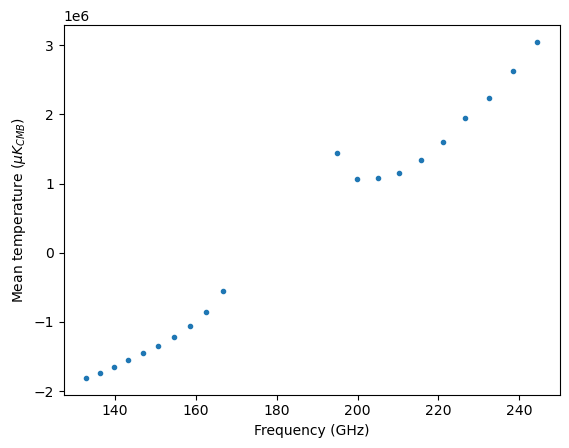

In [5]:
mean_atm_maps = []
for i in range(atm_maps.shape[0]):
    mean_atm_maps.append(np.mean(atm_maps[i, :]))
plt.plot(frequencies, mean_atm_maps, '.')
plt.xlabel('Frequency (GHz)')
plt.ylabel(r'Mean temperature ($\mu K_{CMB}$)')

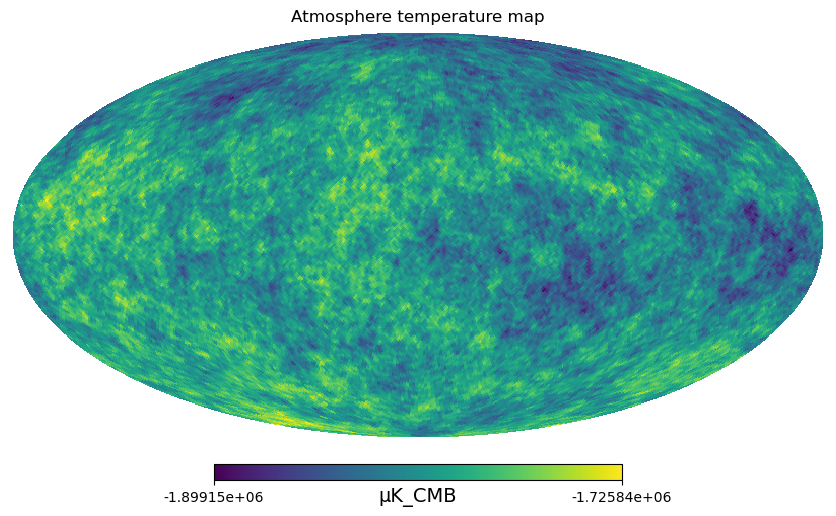

In [6]:
hp.mollview(atm_maps[0], title='Atmosphere temperature map', unit='µK_CMB')

(0.0, 0.0002)

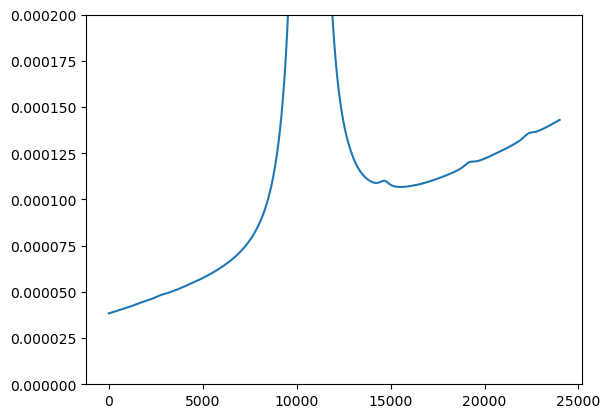

In [7]:
plt.plot(abs_spectrum)
plt.ylim(0, 0.0002)

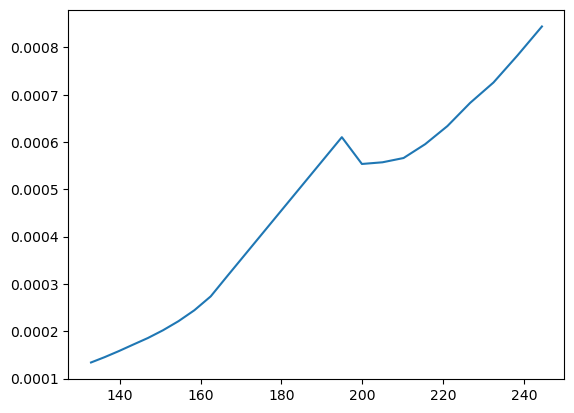

In [8]:
plt.plot(frequencies, integrated_abs_spectrum)

In [9]:
from qubic.scripts.MapMaking.src.FMM.model.planck_timeline import InputMaps
from pyoperators import *
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

In [10]:
cmb_maps = InputMaps({'cmb':42}, atm.frequencies, 2, params['nside']).m_nu

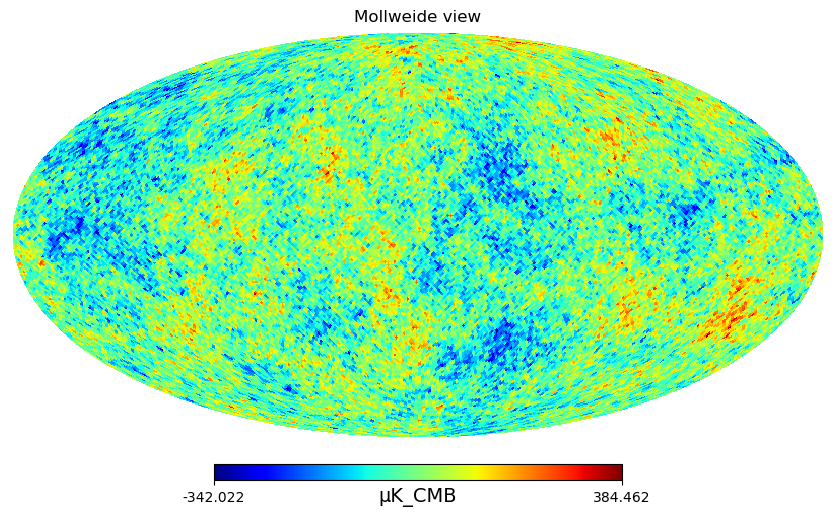

In [11]:
hp.mollview(cmb_maps[-1, :, 0],cmap='jet', unit='µK_CMB')

In [12]:
input_maps = cmb_maps.copy()*0
input_maps[:, :, 0] += atm_maps

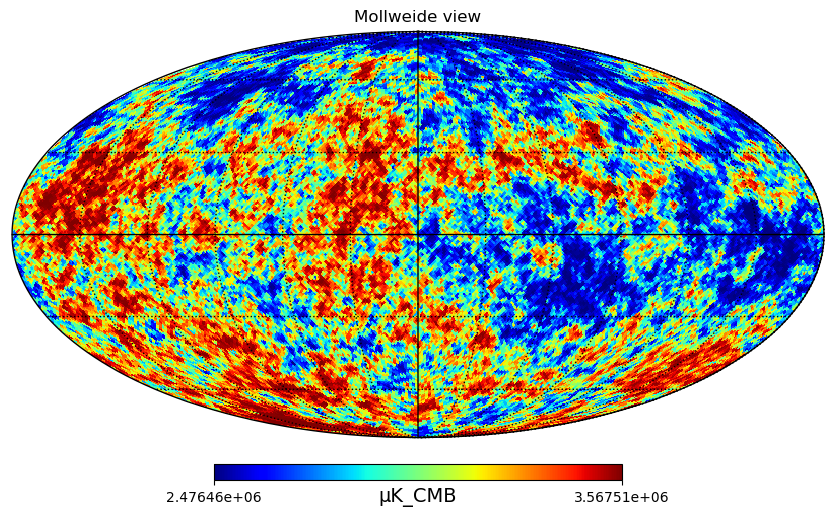

In [13]:
hp.mollview(input_maps[-1, :, 0] ,cmap='jet', unit='µK_CMB', norm='hist')
hp.graticule()

# Map-making

In [14]:
H_tod = qubic.lib.InstrumentModel.Qacquisition.QubicDualBand(atm.qubic_dict, nsub=params['nsub_in'], nrec=params['nsub_in']).get_operator()
Qacq = qubic.lib.InstrumentModel.Qacquisition.QubicDualBand(atm.qubic_dict, nsub=params['nsub_in'], nrec=params['nrec'])
H_rec = Qacq.get_operator()
invN = Qacq.get_invntt_operator()

You asked 1000 pointings with repeat strategy so I will provide 333 pointings repeated 3 times.
Info apcnb2325: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMat

In [15]:
#coverage = joint.qubic.subacqs[0].get_coverage()
coverage = Qacq.coverage
npix_qubic=0
for i in coverage:
    if i!=0:
        npix_qubic+=1
covnorm = coverage / coverage.max()
seenpix = covnorm > 0.2
fsky = seenpix.astype(float).sum() / seenpix.size
coverage_cut = coverage.copy()
coverage_cut[~seenpix] = 1

mask = np.ones(12*params['nside']**2)
mask[seenpix] = 0

center = np.array([0, -57])

In [16]:
print('H_rec', H_rec.shapein, H_rec.shapeout)
print('invN', invN.shapein, invN.shapeout)
R = ReshapeOperator(invN.shapeout, invN.shape[0])
invN = R(invN(R.T))
print('invN', invN.shapein, invN.shapeout)
print('H_tod', H_tod.shapein, H_tod.shapeout)

H_rec (2, 49152, 3) (1982016,)
invN (1984, 999) (1984, 999)
invN (1982016,) (1982016,)
H_tod (20, 49152, 3) (1984, 999)


In [17]:
true_maps = np.zeros((params['nrec'], 12*params['nside']**2, 3))
true_frequencies = np.zeros(params['nrec'])
fsub = int(params['nsub_in'] / params['nrec'])
for i in range(params['nrec']):
    true_maps[i, :, :] = np.mean(input_maps[i*fsub:(i+1)*fsub, :, :], axis=0)
    true_frequencies[i] = np.mean(frequencies[i*fsub:(i+1)*fsub])
print(true_maps.shape)    

(2, 49152, 3)


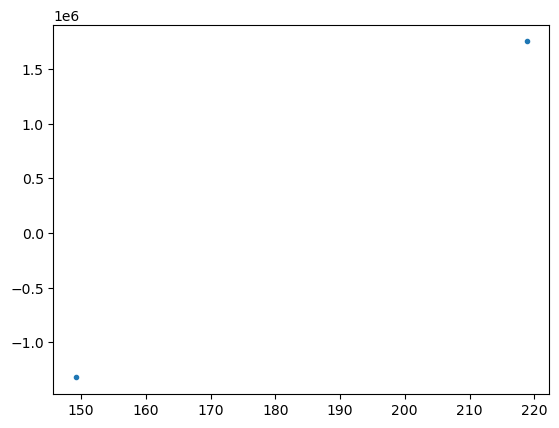

In [18]:
plt.plot(true_frequencies, np.mean(true_maps, axis=1)[..., 0], '.')

In [19]:
print(np.max(true_maps[0,:,0]))
print(np.min(true_maps[0,:,0]))

-1194241.8354140245
-1459725.4919211804


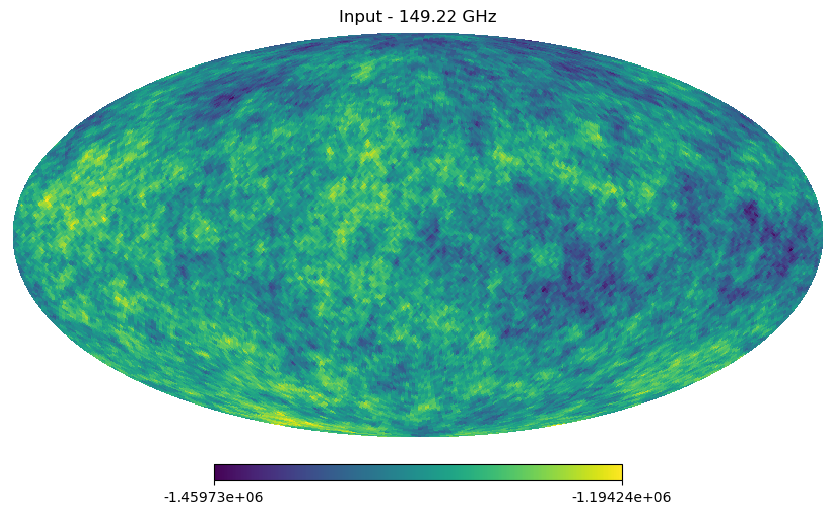

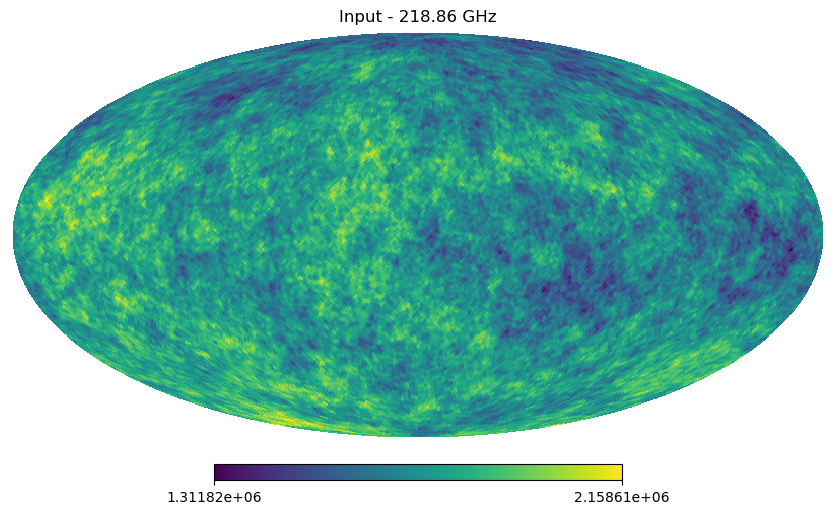

In [20]:
for inu in range(len(true_frequencies)):
    hp.mollview(true_maps[inu, :, 0],title='Input - {:.2f} GHz'.format(true_frequencies[inu]))

In [21]:
tod = H_tod(input_maps).ravel()
A = H_rec.T * invN * H_rec
b = H_rec.T * invN * tod
x0 = true_maps*0.1

In [22]:
print('A', A.shapein, A.shapeout)
print('b', b.shape)

A (2, 49152, 3) (2, 49152, 3)
b (2, 49152, 3)


In [23]:
approx_hth = np.zeros((x0.shape))
conditioner = np.zeros((x0.shape))
vec = np.ones(Qacq.H[0].shapein)

for i in range(x0.shape[0]):
    for j in range(x0.shape[0]):
        approx_hth[i] = (
            Qacq.H[i].T
            * Qacq.invn220
            * Qacq.H[j](vec)
        )
fsub_out = int(params["nsub_in"] / params["nrec"])
for irec in range(params["nrec"]):
    imin = irec * fsub_out
    imax = (irec + 1) * fsub_out
    for istk in range(3):
        conditioner[irec, seenpix, istk] = 1 / (
            np.sum(approx_hth[imin:imax, seenpix, 0], axis=0)
        )

conditioner[conditioner == np.inf] = 1
M = DiagonalOperator(conditioner)

In [24]:
print(M.shapein, M.shapeout)

(2, 49152, 3) (2, 49152, 3)


In [38]:
import time
from qubic.lib.Qcg import PCGAlgorithm
time0 = time.time()
algo = PCGAlgorithm(
    A,
    b,
    comm,
    x0=x0,
    tol=1e-10,
    maxiter=300,
    disp=True,
    M=None,
    center=[0, -57],
    reso=15,
    seenpix=seenpix,
    input=true_maps,
)
try:
    output = algo.run()
    success = True
    message = 'Success'
except AbnormalStopIteration as e:
    output = algo.finalize()
    success = False
    message = str(e)

 Iter     Tol      time
   1: 1.4434e-01 1.36123 [1.31101380e+05 4.17341685e-12 4.83880027e-12 6.32255163e+05
 2.33877996e-11 2.67708763e-11]
   2: 3.9003e-02 1.33691 [4.54333871e+05 1.59333206e-11 1.86611303e-11 3.43055412e+05
 4.67297551e-11 5.32835538e-11]
   3: 1.7289e-02 1.33723 [2.93893322e+05 2.16425290e-11 2.53476087e-11 4.18422417e+05
 4.56388796e-11 5.26216308e-11]
   4: 1.2605e-02 1.41515 [2.47162930e+05 2.51844481e-11 2.92009600e-11 4.13809923e+05
 3.52213595e-11 4.10875781e-11]
   5: 8.8755e-03 1.42596 [2.81075670e+05 4.03647327e-11 4.55118540e-11 2.80871291e+05
 6.84366225e-11 7.35955776e-11]
   6: 5.0111e-03 1.42664 [3.06205197e+05 3.89629092e-11 4.37994630e-11 2.46207349e+05
 4.19797205e-11 4.40153559e-11]
   7: 4.8404e-03 1.33439 [3.08187328e+05 3.13011666e-11 3.50702120e-11 2.13987101e+05
 3.47363832e-11 3.99980245e-11]
   8: 6.7876e-03 1.29873 [2.87951623e+05 2.11448319e-11 2.33084384e-11 1.67058620e+05
 6.17459709e-11 7.06712346e-11]
   9: 5.2262e-03 1.32181 [2.4142

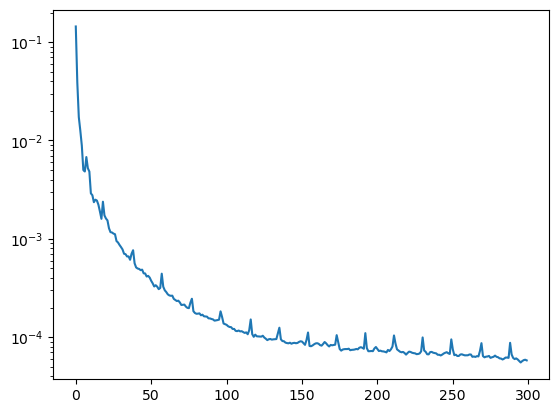

In [44]:
plt.plot(output['convergence'])
plt.yscale('log')

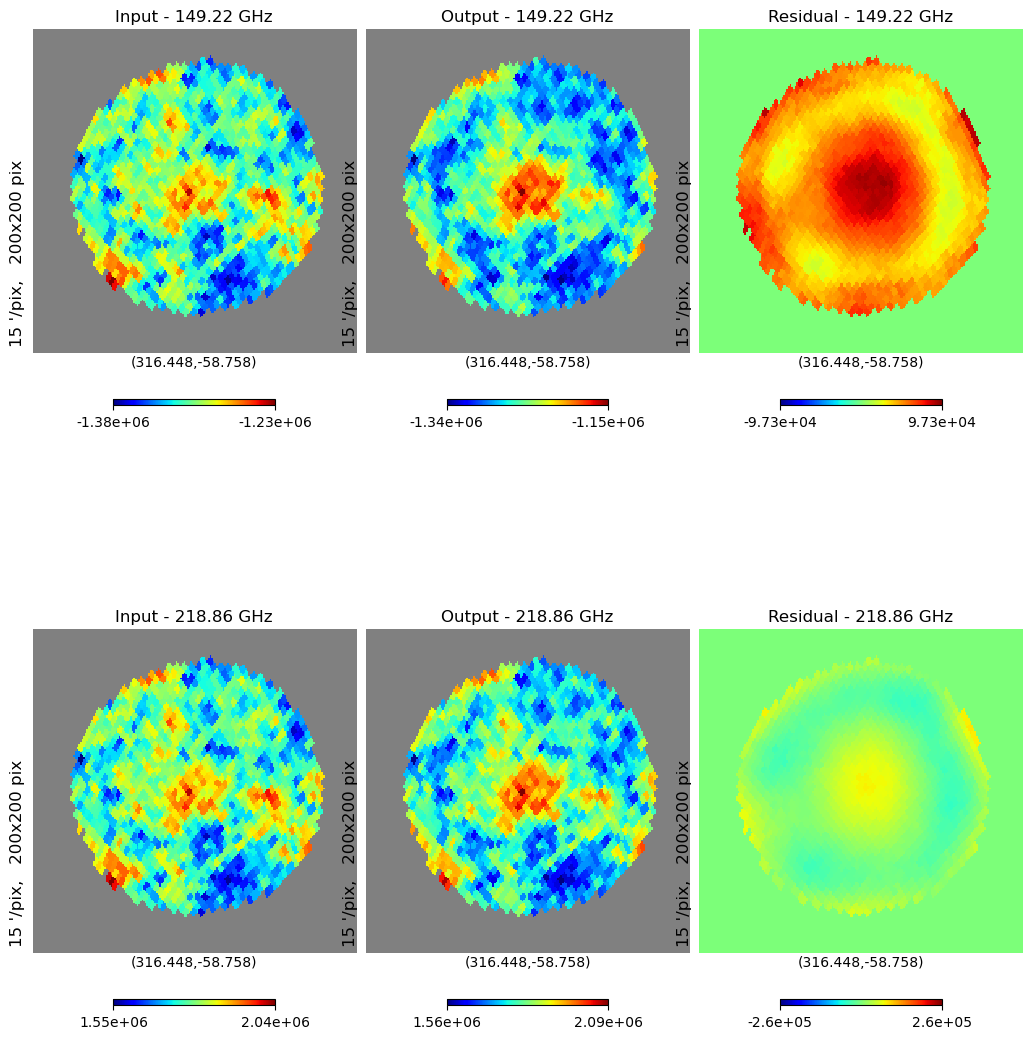

In [40]:
plt.figure(figsize=(10, 12))
istk = 0
k=1
true_maps[:, ~seenpix, :] = hp.UNSEEN
output['x'][:, ~seenpix, :] = hp.UNSEEN

n_sig = 3

for inu in range(output['x'].shape[0]):
    sigma = np.std(output['x'][inu, seenpix, istk])
    hp.gnomview(true_maps[inu, :, istk], cmap='jet', rot=qubic_patch,title='Input - {:.2f} GHz'.format(true_frequencies[inu]), reso=15, sub=(output['x'].shape[0], 3, k))
    hp.gnomview(output['x'][inu, :, istk], cmap='jet', rot=qubic_patch,title='Output - {:.2f} GHz'.format(true_frequencies[inu]), reso=15, sub=(output['x'].shape[0], 3, k+1))
    hp.gnomview(output['x'][inu, :, istk] - true_maps[inu, :, 0], min=-n_sig*sigma, max=n_sig*sigma, cmap='jet', rot=qubic_patch,title='Residual - {:.2f} GHz'.format(true_frequencies[inu]), reso=15, sub=(output['x'].shape[0], 3, k+2))
    k+=3

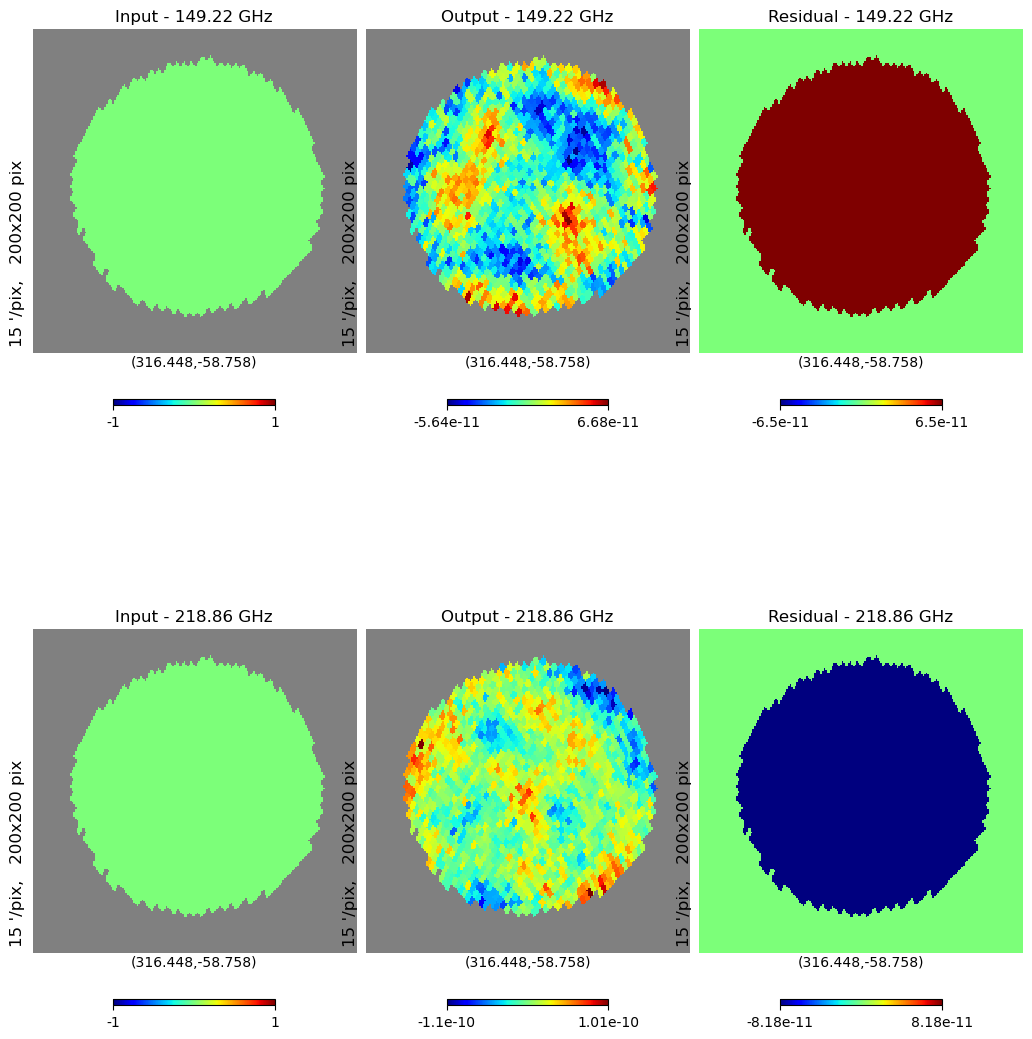

In [45]:
plt.figure(figsize=(10, 12))
istk = 1
k=1
true_maps[:, ~seenpix, :] = hp.UNSEEN
output['x'][:, ~seenpix, :] = hp.UNSEEN

n_sig = 3

for inu in range(output['x'].shape[0]):
    sigma = np.std(output['x'][inu, seenpix, istk])
    hp.gnomview(true_maps[inu, :, istk], cmap='jet', rot=qubic_patch,title='Input - {:.2f} GHz'.format(true_frequencies[inu]), reso=15, sub=(output['x'].shape[0], 3, k))
    hp.gnomview(output['x'][inu, :, istk], cmap='jet', rot=qubic_patch,title='Output - {:.2f} GHz'.format(true_frequencies[inu]), reso=15, sub=(output['x'].shape[0], 3, k+1))
    hp.gnomview(output['x'][inu, :, istk] - true_maps[inu, :, 0], min=-n_sig*sigma, max=n_sig*sigma, cmap='jet', rot=qubic_patch,title='Residual - {:.2f} GHz'.format(true_frequencies[inu]), reso=15, sub=(output['x'].shape[0], 3, k+2))
    k+=3

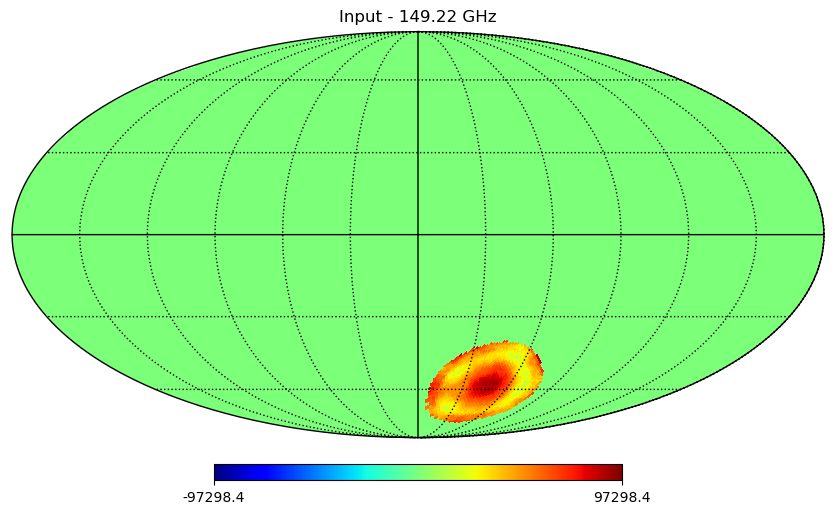

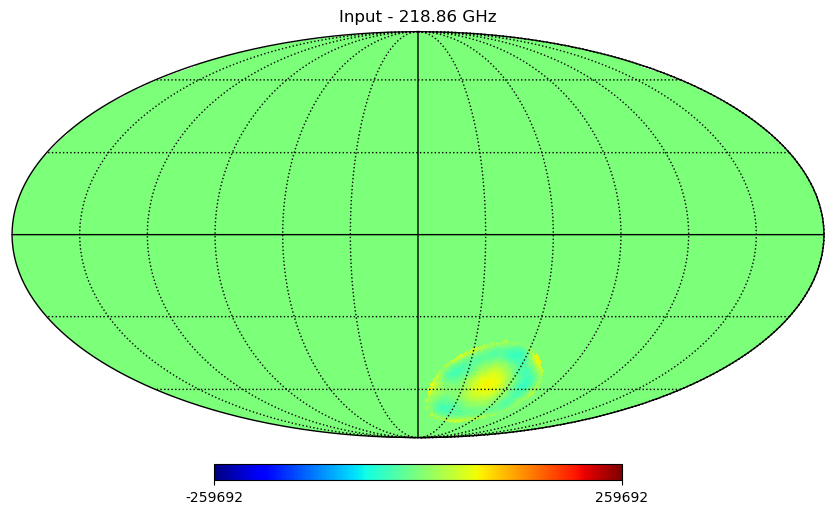

In [41]:
for inu in range(output['x'].shape[0]):
    sigma = np.std(output['x'][inu, seenpix, istk])
    hp.mollview(output['x'][inu, :, 0] - true_maps[inu, :, 0], min=-n_sig*sigma, max=n_sig*sigma, cmap='jet',title='Input - {:.2f} GHz'.format(true_frequencies[inu]))
    hp.graticule()

In [29]:
stop

NameError: name 'stop' is not defined

In [13]:
from lib.InstrumentModel.Qacquisition import QubicMultiAcquisitions

ModuleNotFoundError: No module named 'lib'

In [10]:
def get_dict(params, comm, key='in'):
    """QUBIC dictionary.

    Method to modify the qubic dictionary.

    Parameters
    ----------
    key : str, optional
        Can be "in" or "out".
        It is used to build respectively the instances to generate the TODs or to reconstruct the sky maps,
        by default "in".

    Returns
    -------
    dict_qubic: dict
        Modified QUBIC dictionary.

    """

    args = {
        "npointings": params["QUBIC"]["npointings"],
        "nf_recon": params["QUBIC"]["nrec"],
        "nf_sub": params["QUBIC"][f"nsub_{key}"],
        "nside": params["SKY"]["nside"],
        "MultiBand": True,
        "period": 1,
        "RA_center": params["SKY"]["RA_center"],
        "DEC_center": params["SKY"]["DEC_center"],
        "filter_nu": 150 * 1e9,
        "noiseless": False,
        "comm": comm,
        "dtheta": params["QUBIC"]["dtheta"],
        "nprocs_sampling": 1,
        "nprocs_instrument": comm.Get_size(),
        "photon_noise": True,
        "nhwp_angles": 3,
        #'effective_duration':3,
        "effective_duration150": 3,
        "effective_duration220": 3,
        "filter_relative_bandwidth": 0.25,
        "type_instrument": "two",
        "TemperatureAtmosphere150": None,
        "TemperatureAtmosphere220": None,
        "EmissivityAtmosphere150": None,
        "EmissivityAtmosphere220": None,
        "detector_nep": float(params["QUBIC"]["NOISE"]["detector_nep"]),
        "synthbeam_kmax": params["QUBIC"]["SYNTHBEAM"]["synthbeam_kmax"],
    }

    ### Get the default dictionary
    dictfilename = "dicts/pipeline_demo.dict"
    dict_qubic = qubic.lib.Qdictionary.qubicDict()
    dict_qubic.read_from_file(dictfilename)

    for i in args.keys():

        dict_qubic[str(i)] = args[i]

    return dict_qubic